In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl import load_workbook
# /https://openpyxl.readthedocs.io/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

wb2 = load_workbook('SampleData_TuberWeight_CatalystAI.xlsx')

df = pd.DataFrame(wb2['Sample Data (training)'].values)
df = df.dropna()
for index, row in df.iterrows():
    if index == 0:
        continue
    row[6] = row[4]**(1/3)

In [3]:
batches = []
sigma = 3
counts = np.asarray(df.loc[df[1] == 30][2])

rand_sample = sigma*np.random.randn(counts.sum())

index = 0
for c in counts:
    batches.append(np.sum(rand_sample[index:index+c]))
    index += c
    
sample_var = 0
for sum_mass, num_potato in list(zip(batches, counts)):
    sample_var += sum_mass**2/num_potato
sample_var /= len(counts)

sample_var_rand_sample = 0
for c in rand_sample:
    sample_var_rand_sample += c**2
sample_var_rand_sample /= len(rand_sample)


print(sample_var**(1/2))
print(sample_var_rand_sample**(1/2))

2.917858471660255
3.0421594221148744


In [4]:

# print(band_to_samples)

In [5]:
def pi_estimate(band_to_samples, smoothing=0):
    pi_sum = {}
    num_potatoes = 0
    for band in band_to_samples:
        total_sum = 0
        for (batch_size, batch_weight) in band_to_samples[band]:
            total_sum += batch_size
        pi_sum[band] = total_sum+smoothing
        num_potatoes += total_sum
    pi_dist = {}
    for band in pi_sum:
        pi_dist[band] = pi_sum[band]/num_potatoes
    return pi_dist


In [6]:
def estimate_mu(band_to_samples):
    mu = {}
    for band in band_to_samples:
        total_weight = 0
        total_potatoes = 0
        for (batch_size, batch_weight) in band_to_samples[band]:
            total_weight += batch_weight
            total_potatoes += batch_size
        mu[band] = total_weight/total_potatoes
    return mu


In [7]:
def estimate_var(band_to_samples, mu_estimate):
    var = {}
    for band in band_to_samples:
        square_diff_sum = 0 
        for (batch_size, batch_weight) in band_to_samples[band]:
            square_diff_sum += (batch_weight - batch_size*mu_estimate[band])**2/batch_size
        var[band] = square_diff_sum/len(band_to_samples[band])
    return var


In [8]:
import scipy.stats

def get_posterior(weight, band_to_samples, pi_estimate, mu_estimate, var_estimate):
    post_prop = {}
    sum_post = 0
    post = {}
    for band in band_to_samples:
        norm_dist = scipy.stats.norm(mu_estimate[band], var_estimate[band]**(1/2))
        post_prop[band] = norm_dist.pdf(weight)*pi_estimate[band]
        sum_post += post_prop[band]
    for band in post_prop:
        post[band] = post_prop[band]/sum_post
    return post

def get_argmax(posterior):
    key_max = None
    max_value = 0.0
    for band in posterior:
        if posterior[band] > max_value:
            max_value = posterior[band]
            key_max = band
    return key_max
    
def get_entropy(posterior):
    H = 0
    for band in posterior:
        if posterior[band] < 1e-50:
            continue
        H += -posterior[band]*np.log(posterior[band])
    return H


    

In [9]:
colors = {}
colors[20] = 'blue'
colors[30] = 'green'
colors[40] = 'red'
colors[50] = 'cyan'
colors[60] = 'magenta'
colors[70] = 'black'
colors[80] = 'orange'

In [10]:
min_weight = 100000
max_weight = 0 
band_to_samples = {} 
for band, batch_size, batch_weight in zip(df[1][1:], df[2][1:], df[3][1:]):
    if band == 90:
        continue
    if band in band_to_samples:
        band_to_samples[band].append((batch_size,batch_weight))
    else:
        band_to_samples[band] = [(batch_size, batch_weight)]
        min_weight = min(min_weight, band_to_samples[band][-1][1]/band_to_samples[band][-1][0])
        max_weight = max(max_weight, band_to_samples[band][-1][1]/band_to_samples[band][-1][0])
print(band_to_samples)

{80: [(2, 0.644999980926513), (2, 0.694999992847442), (2, 0.709999978542327), (1, 0.365000009536743), (1, 0.370000004768371), (1, 0.370000004768371), (1, 0.375), (1, 0.379999995231628), (9, 3.43499994277954), (2, 0.764999985694885), (2, 0.785000026226043), (3, 1.2150000333786), (1, 0.414999991655349), (3, 1.26999998092651), (5, 2.16000008583068), (1, 0.435000002384185), (5, 2.20499992370605), (1, 0.449999988079071), (2, 0.964999973773956), (1, 0.490000009536743), (1, 0.495000004768371), (1, 0.524999976158142)], 50: [(37, 3.04999995231628), (44, 3.65000009536743), (60, 5.3600001335144), (40, 3.59999990463256), (24, 2.21000003814697), (40, 3.71000003814697), (48, 4.45499992370605), (41, 3.81500005722045), (67, 6.26999998092651), (41, 3.875), (30, 2.84500002861022), (41, 3.90000009536743), (71, 6.78999996185302), (27, 2.58999991416931), (54, 5.20499992370605), (29, 2.79999995231628), (40, 3.89000010490417), (64, 6.2849998474121), (27, 2.65499997138977), (25, 2.46000003814697), (47, 4.6300

In [11]:
pi = pi_estimate(band_to_samples, smoothing=30)
mu = estimate_mu(band_to_samples)
var = estimate_var(band_to_samples, mu)
print(pi)
print(mu)
print(var)

{80: 0.01364590622813156, 50: 0.2988103568929321, 20: 0.0363890832750175, 70: 0.10619314205738278, 40: 0.17914625612316304, 60: 0.3009097270818754, 30: 0.1016445066480056}
{80: 0.4066666644066567, 50: 0.0982747320196767, 20: 0.006853932608965397, 70: 0.2695927222225445, 40: 0.049657947850419104, 60: 0.17143491175047723, 30: 0.021188747590769417}
{80: 0.00421761354460883, 50: 0.0017529664550999034, 20: 1.0395108401974025e-05, 70: 0.009407009866873444, 40: 0.0003128519751440607, 60: 0.0051019605545705015, 30: 8.45920113265986e-05}


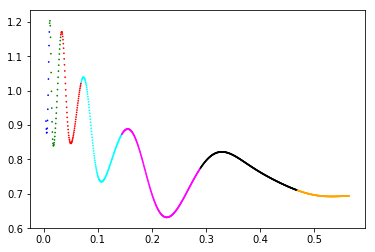

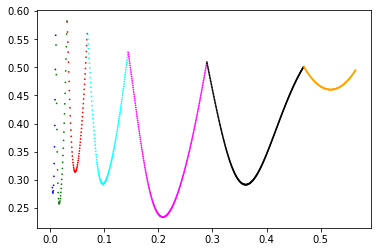

In [12]:
weights = np.linspace(0.75*min_weight, 1.75*max_weight, 1000)
entropy = []
prob_confidence = []
plot_color = []
for w in weights:
    posterior = get_posterior(w, band_to_samples, pi, mu, var)
    argmax = get_argmax(posterior)
    entropy.append(get_entropy(posterior))
    prob_confidence.append(1-posterior[argmax])
    plot_color.append(colors[argmax])

plt.scatter(weights, entropy, s = 0.5, c = plot_color)
plt.show()
plt.scatter(weights, prob_confidence, s = 0.5, c = plot_color)
plt.show()